# Airbnb Price Prediction in NYC

### Problem Definition
This project aims to predict the price of Airbnb listings in NYC based on proximity to key landmarks, as well as other features such as accommodates, bedrooms, and minimum nights.

### Project Goal
The objective of this project is to build a model that can accurately predict Airbnb listing prices in NYC. This involves analyzing features such as proximity to key landmarks, accommodations, and other listing attributes.

### Real-world Impact
Accurate price prediction allows hosts to adjust rates based on demand, location, and amenities, potentially increasing booking rates and profitability. Insights gained from this model could also be valuable to rental platforms and pricing strategy consultants.



## Dataset Description

We are using a sample dataset of Airbnb listings in NYC with various features, including location data and calculated distances to major landmarks.

### Overview
The dataset consists of Airbnb listings in NYC, including data on accommodations, location, and distances to key landmarks.

### Key Features
- **Listing Features**: Accommodations, bedrooms, minimum nights, and instant booking options.
- **Location Data**: Latitude, longitude, and zip code.
- **Landmark Proximity**: Distances to notable NYC landmarks (e.g., Central Park, Brooklyn Museum).

### Data Limitations
The dataset may have some limitations, such as missing values or limited geographical coverage, which could affect model performance and generalizability.



In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load the dataset
data = pd.read_csv('airbnb_sample_landmarks_zipcodes.csv')


# Display the first few rows to understand the structure
data.head()

,id,last_scraped,latitude,longitude,accommodates,bedrooms,price,minimum_nights,instant_bookable,calculated_host_listings_count_entire_homes,...,wall_street_log_dist,whitney_museum_log_dist,yankee_stadium_log_dist,mean_dist_landmarks,median_dist_landmarks,num_landmarks_dist_500m,closest_landmark,mean_log_dist_landmarks,median_log_dist_landmarks,zip_code
0,1111670028116667408,2024-09-04,40.764024,-73.971064,6,2.0,10.0,1,1,3,...,8.880063,8.340383,9.013455,4480.528407,2376.390046,1,central_park_zoo,7.903638,7.773217,10022.0
1,50444487,2024-09-05,40.775860,-73.960990,2,1.0,10.0,30,0,4,...,9.076169,8.649401,8.803280,5250.499544,3539.591229,1,metropolitan_museum_of_art,8.229141,8.171751,10075.0
2,48369592,2024-09-05,40.777230,-73.960530,2,1.0,10.0,30,0,4,...,9.093506,8.672854,8.779936,5329.807109,3530.386559,1,metropolitan_museum_of_art,8.238811,8.168128,10028.0
3,817631937375329564,2024-07-05,40.685060,-73.951580,2,1.0,10.0,100,0,1,...,8.588466,8.955719,9.692672,9174.752187,8462.334589,0,brooklyn_museum,9.043020,9.043372,11216.0
4,1330056,2024-09-05,40.717050,-73.957600,2,2.0,10.0,30,0,1,...,8.411457,8.517566,9.455772,6624.881849,5124.466669,0,moma_ps1,8.698065,8.541782,11211.0


## Data Cleaning and Preprocessing

In this section, we handle missing values, encode categorical variables, and engineer features to prepare the data for modeling.

### Cleaning Steps
We first check for missing values and handle them appropriately, then proceed with feature selection and encoding.



In [3]:
# Drop rows with missing values for simplicity
data.dropna(inplace=True)

# Select relevant features for the model
selected_features = [
    'latitude', 'longitude', 'accommodates', 'bedrooms', 'minimum_nights',
    'instant_bookable', 'calculated_host_listings_count_entire_homes',
    'mean_dist_landmarks', 'median_dist_landmarks', 'num_landmarks_dist_500m',
    'closest_landmark', 'price'
]
data = data[selected_features]

# Separate features and target variable
X = data.drop(columns=['price'])
y = data['price']


## Exploratory Data Analysis (EDA)

In this section, we explore the data to identify trends and relationships among features. Visualizations help reveal potential correlations that may be useful in the modeling phase.

### Key Insights
- Correlations between proximity to landmarks and price.
- Distribution of prices across different neighborhoods and accommodations.



## Model Selection and Evaluation

### Model Choices
We will use a RandomForestRegressor for predicting prices due to its ability to handle feature importance and non-linear relationships. Additional models could include linear regression for baseline comparison.

### Train-Test Split and Parameters
The data is split into training and testing sets (80-20 split). Parameters for the RandomForest include:
- **n_estimators**: Number of trees set to 50 to reduce training time.
- **max_depth**: Limited to 10 to avoid overfitting.



In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for 'closest_landmark' (One-hot encoding)
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), ['closest_landmark'])],
    remainder='passthrough'
)

# Create a pipeline for RandomForest with limited depth
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42))
])

# Define RMSE as the scoring metric
scoring = {'rmse': make_scorer(mean_squared_error, squared=False)}

# Perform cross-validation to calculate training and test scores
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

# Calculate mean training and test RMSE using the correct keys
mean_train_rmse = cv_results['train_rmse'].mean() if 'train_rmse' in cv_results else cv_results['train_score'].mean()
mean_test_rmse = cv_results['test_rmse'].mean() if 'test_rmse' in cv_results else cv_results['test_score'].mean()

print(f"Cross-validated Mean Training RMSE: {mean_train_rmse}")
print(f"Cross-validated Mean Test RMSE: {mean_test_rmse}")

# Fit the model on the full training data
pipeline.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = pipeline.predict(X_test)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Final Test RMSE: {rmse}")
print(f"R-squared: {r2}")

Cross-validated Mean Training RMSE: 189.71341473609806
Cross-validated Mean Test RMSE: 346.5611507614129
Final Test RMSE: 418.5095928173938
R-squared: 0.25300132982813694

## Results and Visualization

The following visualizations provide insights into the model's performance.

- **Predicted vs Actual Prices**: Scatter plot comparing predicted prices to actual prices.
- **Top Feature Importances**: Identifies the most influential features impacting predictions.



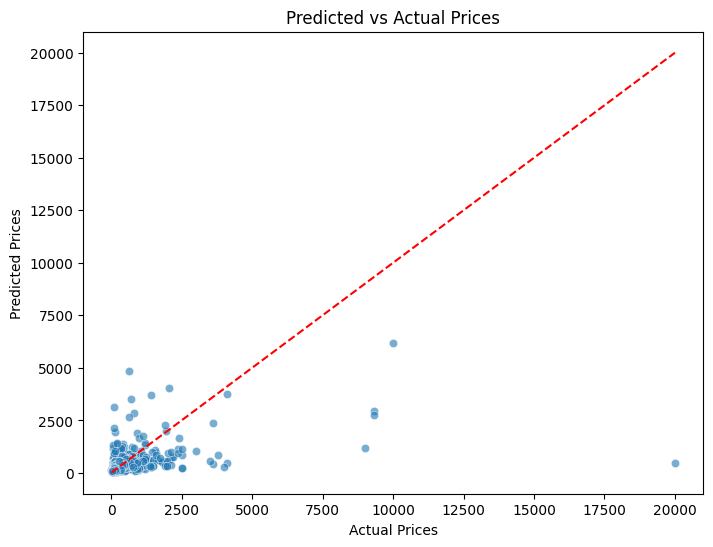

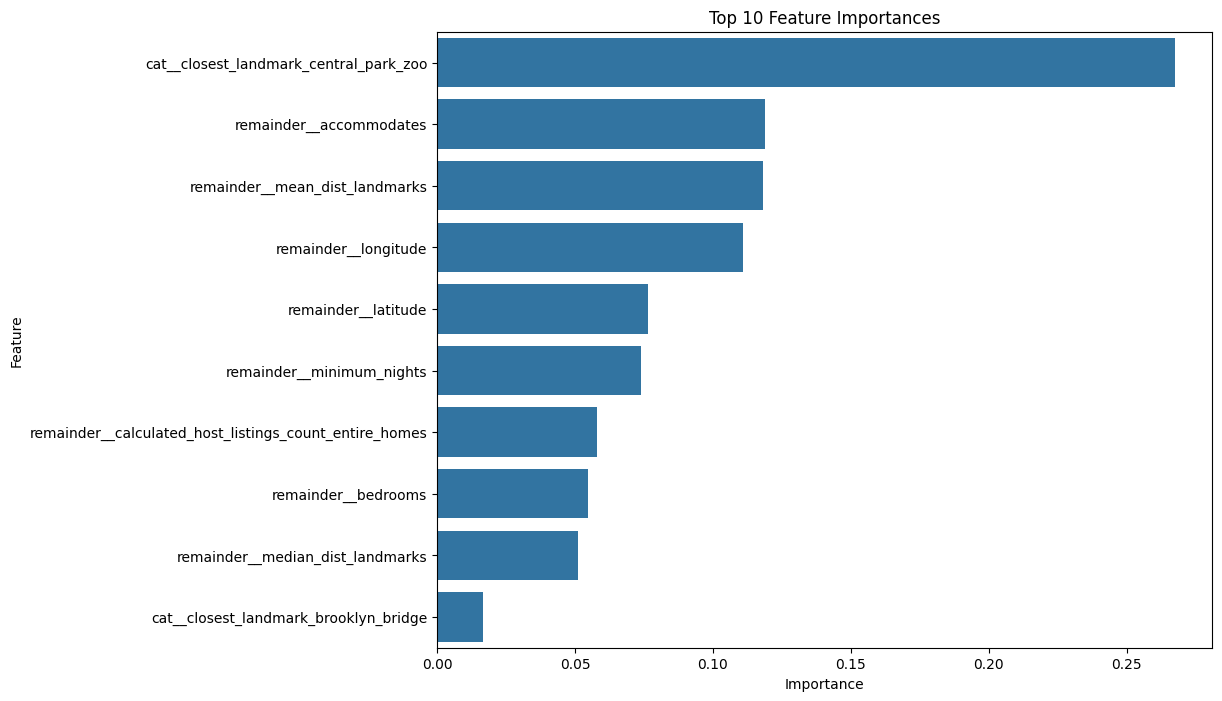

In [5]:
# Predicted vs Actual prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices')
plt.show()

# Feature Importance visualization
feature_importances = pipeline.named_steps['model'].feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Conclusion

### Summary
Our model provides a predictive analysis of Airbnb listing prices in NYC, using features such as accommodations and proximity to landmarks. The RandomForest model performed moderately well but could benefit from further tuning.

### Feature Engineering
Transformations or new features created, such as log transformations for highly correlated variables or one-hot encoding for categorical features.
Feature engineering allows us to extract more insights from our data. We applied a log transformation to variables like price and certain highly correlated features to meet the assumptions for our linear model. Additionally, we used one-hot encoding to handle categorical variables like room type and neighborhood group, allowing these categories to contribute individually to our model.

Now that we've completed the feature engineering phase, let's listen to a brief summary using Text-to-Speech.



In [ ]:
import pyttsx3

# Initialize the TTS engine
engine = pyttsx3.init()

# Define the text to be read aloud
feature_engineering_text = """
In the feature engineering phase, we transformed our variables to better align with model requirements.
We applied log transformations to highly correlated variables to stabilize variance and meet linear model assumptions.
Additionally, we used one-hot encoding to convert categorical variables like room type and neighborhood group.
"""

# Set properties before speaking
engine.setProperty('rate', 150)  # Speed of speech
engine.setProperty('volume', 0.9)  # Volume level between 0 and 1

# Play the text-to-speech
engine.say(feature_engineering_text)
engine.runAndWait()